<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry_He)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-algorithms==0.3.1
%pip install qiskit-nature[pyscf]==0.7.2
#%pip install pyscf==2.6.0
%pip install py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=ce26440ea26e6c395e65940e7cafb07d28b57093b3c3e996b4a2282b9f74dd63
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import datetime
import time

# 분자 구조(좌표)를 입력할 때 길이의 단위를 명확하게 지정하기 위한 열거형(Enum) 클래스, Ångström이야? Bohr이야? nm이야?”
from qiskit_nature.units import DistanceUnit

#First quantization(제1 양자화): 실제 분자의 전자 구조(오비탈, 에너지, 1체/2체 적분 등)를 고전적으로 정확히 계산해서 양자 컴퓨터가 쓸 수 있는 2차 양자화 해밀토니안으로 바꿔주는 핵심 브릿지 역할, 쉽게 말해,
# H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안으로 변환해 줌”
from qiskit_nature.second_q.drivers import PySCFDriver, Psi4Driver, GaussianDriver, ElectronicStructureDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

#Second quantization(제2 양자화): 양자 다체계 문제를 효율적으로 모델링하기 위한 핵심 기법입니다. 이는 생성(creation)과 소멸(annihilation) 연산자를 사용해 해밀토니안을 표현하는 방식으로,
# 각 Problem 클래스(ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem)는 second_q_ops() 메서드를 통해
# second-quantized operator(주로 FermionicOp 또는 BosonicOp 형태)를 생성합니다. 이 연산자는 이후 QubitMapper(Jordan-Wigner, Parity 등)를 통해 큐비트 연산자로 변환되어 양자 알고리즘(VQE 등)에서 사용
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

#실행하기 전에 분자 해밀토니안을 작고 계산 가능한 크기로 줄여주는 전처리 도구
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer

#from qiskit_nature.second_q.mappers.QubitConverter import QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem
from qiskit_nature.second_q.algorithms import GroundStateSolver, GroundStateEigensolver, ExcitedStatesSolver, ExcitedStatesEigensolver, QEOM, QEOMResult, EvaluationRule

#Classical Optimizer
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD

#Aanstz
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal

#Hartree-Fock (HF) 방법은 양자 화학에서 다전자 원자나 분자의 전자 구조를 근사적으로 계산하는 기본적인 방법입니다.
#"Hartree-Fock solution", 이 방법으로 얻어진 최적화된 파동함수와 에너지를 의미하며, 정확한 슈뢰딩거 방정식 해가 아닌 최선의 단일 Slater determinant 근사
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

#from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

In [12]:
# 1. 분자 지오메트리 정의 (He-He, 2.97 Angstrom)
he2_geometry = "He 0.0 0.0 0.0; He 0.0 0.0 2.97"
driver = PySCFDriver(
    atom=he2_geometry,
    #basis="sto3g",   # 가벼운 계산을 위해 STO-3G 사용
    basis="6-31g",      # sto-3g 에러로, 대신 더 큰 기저 집합 사용 (공간 오비탈 수 증가)
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

In [13]:
# 2. 양자 문제 생성 (Electronic Structure Problem)
problem = driver.run()

In [14]:
# 오비탈 수와 전자 수 확인 (디버깅용)
print(f"Number of spatial orbitals: {problem.num_spatial_orbitals}")
print(f"Number of particles: {problem.num_particles}")

Number of spatial orbitals: 4
Number of particles: (2, 2)


In [15]:
# 위 코드의 2번 단계(problem 생성) 이후에 아래 코드를 추가해보세요.
nuclear_repulsion_energy = problem.nuclear_repulsion_energy
print(f"Nuclear Repulsion Energy: {nuclear_repulsion_energy} Hartree")

Nuclear Repulsion Energy: 0.7126965803636364 Hartree


In [16]:
FermionicOp = problem.second_q_ops()[0]
print(FermionicOp)

Fermionic Operator
number spin orbitals=8, number terms=528
  0.30028696757588513 * ( +_0 +_0 -_0 -_0 )
+ -0.07896626681400049 * ( +_0 +_0 -_2 -_0 )
+ 0.30126772836066945 * ( +_0 +_1 -_1 -_0 )
+ 0.07863298012020964 * ( +_0 +_1 -_3 -_0 )
+ -0.07896626681400049 * ( +_0 +_2 -_0 -_0 )
+ 0.25873019241225503 * ( +_0 +_2 -_2 -_0 )
+ 0.07863298012020964 * ( +_0 +_3 -_1 -_0 )
+ 0.25871112345787806 * ( +_0 +_3 -_3 -_0 )
+ 0.30028696757588513 * ( +_0 +_4 -_4 -_0 )
+ -0.07896626681400049 * ( +_0 +_4 -_6 -_0 )
+ 0.30126772836066945 * ( +_0 +_5 -_5 -_0 )
+ 0.07863298012020964 * ( +_0 +_5 -_7 -_0 )
+ -0.07896626681400049 * ( +_0 +_6 -_4 -_0 )
+ 0.25873019241225503 * ( +_0 +_6 -_6 -_0 )
+ 0.07863298012020964 * ( +_0 +_7 -_5 -_0 )
+ 0.25871112345787806 * ( +_0 +_7 -_7 -_0 )
+ 0.21217954525892185 * ( +_0 +_0 -_1 -_1 )
+ 0.07791969283737853 * ( +_0 +_0 -_3 -_1 )
+ 0.21217954525892185 * ( +_0 +_1 -_0 -_1 )
+ -0.08031775050490647 * ( +_0 +_1 -_2 -_1 )
+ -0.08031775050490647 * ( +_0 +_2 -_1 -_1 )
+ -0.16999

In [17]:
# 3. 해밀토니안을 큐비트 연산자로 매핑
mapper = JordanWignerMapper()
qubit_op = mapper.map(FermionicOp)

In [18]:
print(qubit_op)

SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIIZZ', 'IIIIYZYI', 'IIIIYZYZ', 'IIIIXZXI', 'IIIIXZXZ', 'IIIIIZII', 'IIIIIZIZ', 'IIIIZIII', 'IIIIZIIZ', 'IIIZIIII', 'IIIZIIIZ', 'IYZYIIII', 'IYZYIIIZ', 'IXZXIIII', 'IXZXIIIZ', 'IIZIIIII', 'IIZIIIIZ', 'YZYIIIII', 'YZYIIIIZ', 'XZXIIIII', 'XZXIIIIZ', 'IZIIIIII', 'IZIIIIIZ', 'ZIIIIIII', 'ZIIIIIIZ', 'IIIIIYZY', 'IIIIIYIY', 'IIIIIXZX', 'IIIIIXIX', 'IIIIYYYY', 'IIIIXXYY', 'IIIIYXXY', 'IIIIXYYX', 'IIIIYYXX', 'IIIIXXXX', 'IIYYIIYY', 'IIXXIIYY', 'IIYYIIXX', 'IIXXIIXX', 'YZZYIIYY', 'XZZXIIYY', 'YZZYIIXX', 'XZZXIIXX', 'IYYIIIYY', 'IXXIIIYY', 'IYYIIIXX', 'IXXIIIXX', 'YYIIIIYY', 'XXIIIIYY', 'YYIIIIXX', 'XXIIIIXX', 'IIIIZYZY', 'IIIIZXZX', 'IIIZIYZY', 'IIIZIXZX', 'IYZYIYZY', 'IXZXIYZY', 'IYZYIXZX', 'IXZXIXZX', 'IIZIIYZY', 'IIZIIXZX', 'YZYIIYZY', 'XZXIIYZY', 'YZYIIXZX', 'XZXIIXZX', 'IZIIIYZY', 'IZIIIXZX', 'ZIIIIYZY', 'ZIIIIXZX', 'IIYYYZZY', 'IIXXYZZY', 'IIYYXZZX', 'IIXXXZZX', 'YZZYYZZY', 'XZZXYZZY', 'YZZYXZZX', 'XZZXXZZX', 'IYYIYZZY', 'IXXIYZZY', '

In [19]:
# 4. Ansatz (변분 양자 회로) 설정
# 하트리-포크 상태로 초기화
init_state = HartreeFock(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
)

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=init_state,
)

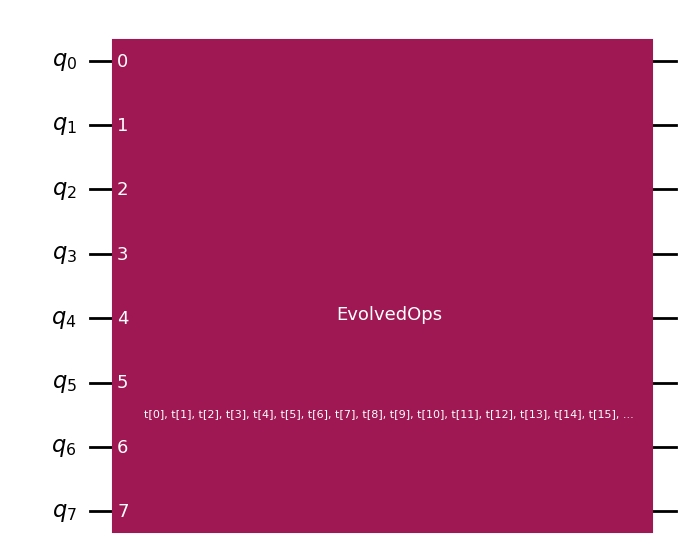

In [20]:
#ansatz.decompose().draw(output="mpl")
ansatz.draw(output="mpl")

In [21]:
# 5. VQE 알고리즘 실행 설정
# VQE 수행 과정 추적을 위한 콜백 함수 정의
history = []

def store_intermediate_result(eval_count, parameters, mean, metadata):
    """콜백 함수: VQE 최적화 과정의 중간 결과를 저장하고 출력합니다."""
    # 'std_dev'는 Estimator 결과의 metadata에 일반적으로 포함되지 않으므로,
    # mean만 기록하거나 metadata의 다른 정보를 활용할 수 있습니다.
    history.append({
        "eval_count": eval_count,
        "parameters": np.array(parameters).tolist(), # NumPy 배열을 리스트로 변환하여 저장
        "mean_energy": mean,
        "metadata": metadata, # metadata 딕셔너리를 직접 저장
        "timestamp": datetime.datetime.now().isoformat()
    })
    # std_dev가 항상 제공되지 않으므로 출력에서 제거했습니다.
    print(f"Iteration {eval_count}: Energy = {mean:.8f}")
###def


# VQE 솔버를 콜백 함수와 함께 다시 설정합니다.
# (이전에 cell e09jdf34xFQ8에서 설정된 vqe_solver를 덮어씁니다.)
#vqe_solver = VQE(Estimator(), ansatz, SLSQP(maxiter=2048), callback=store_intermediate_result)
vqe_solver = VQE(Estimator(), ansatz, COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0), callback=store_intermediate_result)
vqe_solver.initial_point = np.zeros(ansatz.num_parameters)

print("VQE solver가 추적을 위한 콜백과 함께 다시 초기화되었습니다. SLSQP(maxiter=2048)")

VQE solver가 추적을 위한 콜백과 함께 다시 초기화되었습니다. SLSQP(maxiter=2048)


In [22]:
# 6. 에너지 계산
result = vqe_solver.compute_minimum_eigenvalue(operator=qubit_op)
print("Job Done.")

Iteration 1: Energy = -6.42301454
Iteration 2: Energy = -5.08743497
Iteration 3: Energy = -5.05068387
Iteration 4: Energy = -5.09039368
Iteration 5: Energy = -5.05367654
Iteration 6: Energy = -5.08743497
Iteration 7: Energy = -5.05068387
Iteration 8: Energy = -5.09039368
Iteration 9: Energy = -5.05367654
Iteration 10: Energy = -4.03837511
Iteration 11: Energy = -3.62120352
Iteration 12: Energy = -3.68824509
Iteration 13: Energy = -3.72740767
Iteration 14: Energy = -3.79436651
Iteration 15: Energy = -3.68824509
Iteration 16: Energy = -3.54920473
Iteration 17: Energy = -3.79435498
Iteration 18: Energy = -3.65419443
Iteration 19: Energy = -3.72740767
Iteration 20: Energy = -3.79435498
Iteration 21: Energy = -3.62527148
Iteration 22: Energy = -3.69346034
Iteration 23: Energy = -3.79436651
Iteration 24: Energy = -3.65419443
Iteration 25: Energy = -3.69346034
Iteration 26: Energy = -3.55340160
Iteration 27: Energy = -4.03837511
Iteration 28: Energy = -3.51569324
Iteration 29: Energy = -5.467

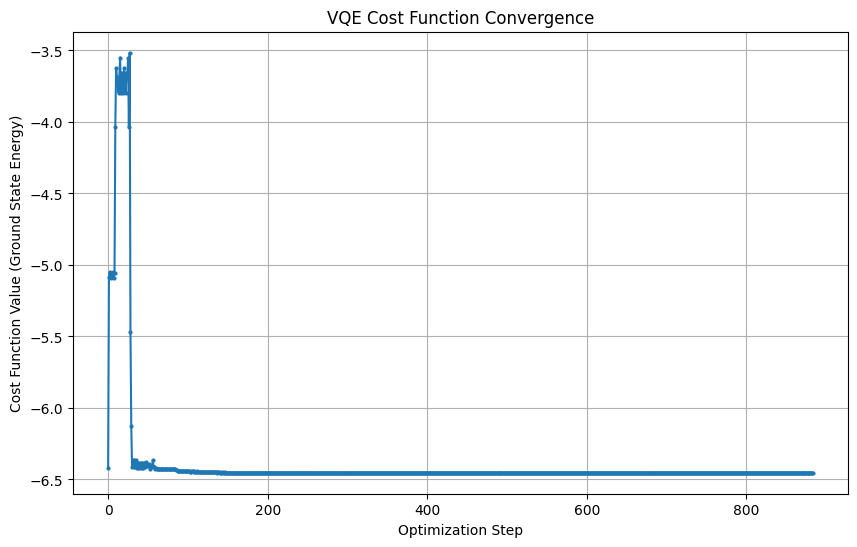

In [23]:
import matplotlib.pyplot as plt

# history 리스트에서 'mean_energy' 값만 추출합니다.
energy_values = [entry['mean_energy'] for entry in history]

plt.figure(figsize=(10, 6))
plt.plot(energy_values, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [24]:
# 7. 결과 해석 (Nuclear Repulsion Energy 포함)
interpretation = problem.interpret(result)
print(f"Total Ground State Energy: {interpretation.total_energies[0] + nuclear_repulsion_energy:.8f} Hartree")

Total Ground State Energy: -5.02762554 Hartree


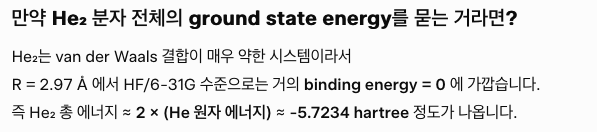